/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59

Pnl ratio for cluster 0: 145667         NaN
145668         NaN
145669         NaN
145670         NaN
145671         NaN
            ...   
285068   -0.138039
285069   -0.138039
285070   -0.138039
285071   -0.138039
285072   -0.138039
Length: 139406, dtype: float64
Pnl ratio for cluster 1: 145667         NaN
145668         NaN
145669         NaN
145670         NaN
145671         NaN
            ...   
285068   -0.512401
285069   -0.512401
285070   -0.512401
285071   -0.512401
285072   -0.512401
Length: 139406, dtype: float64


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Pnl ratio for cluster 2: 145667         NaN
145668         NaN
145669         NaN
145670         NaN
145671         NaN
            ...   
285068    0.195389
285069    0.195389
285070    0.195389
285071    0.195389
285072    0.195389
Length: 139406, dtype: float64


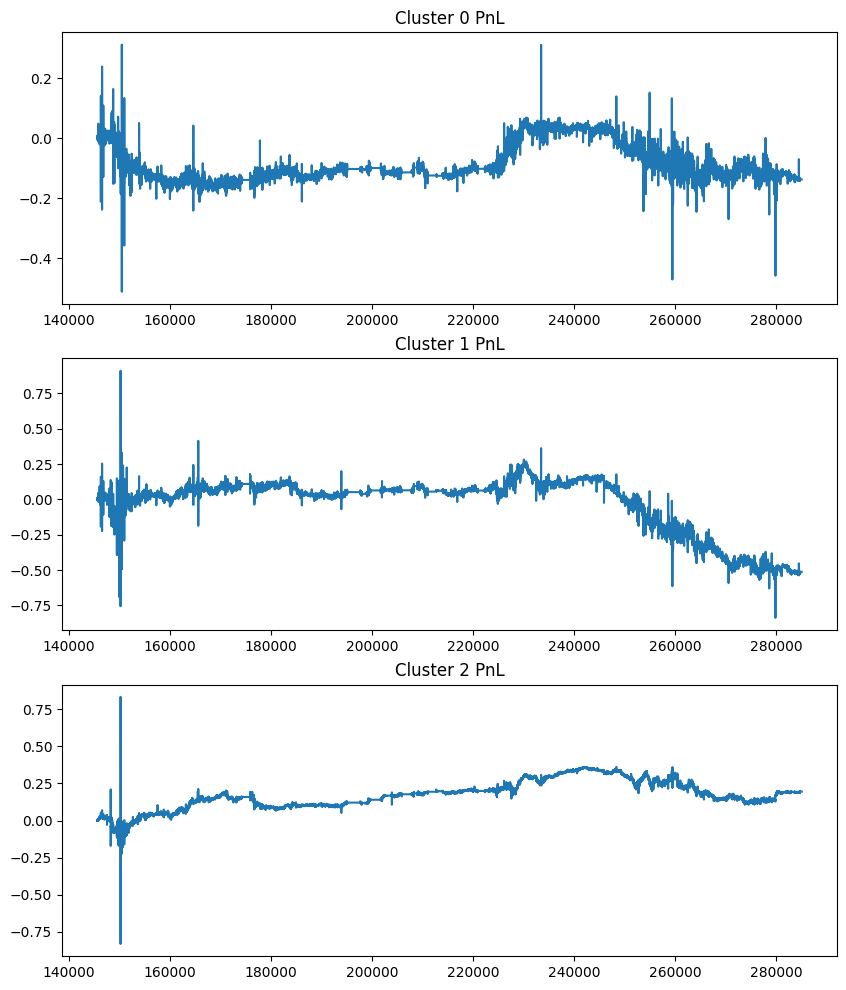

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler
from joblib import load, dump
from xgboost import callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna
import pickle
import joblib 
import os
from sklearn.tree import DecisionTreeRegressor
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

def choose_position(roi, trade_threshold = 0.01):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

def backtest_position_ps(position, price, periods, percentage=0.01):
    #print(periods)
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(int(periods)).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*percentage

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, percentage=fee_perc, periods=periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

def scale_data(data):
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

def split_data(data):
    new_part = np.array_split(data, 3)

    # Access each part individually
#     hold_out = new_part[2]
#     train_data = pd.concat([new_part[0], new_part[1]], axis=0)
    hold_out = pd.concat([new_part[0], new_part[1]], axis=0)
    train_data =  new_part[2]
    return train_data, hold_out

def split_optuna_data(data):
        train_data, _ = split_data(data)
        optuna_data = train_data.drop(['close', 'open','high','low','volume', 'Return'], axis=1)
        optuna_data = scale_data(optuna_data)
        X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

        return X_train, X_valid, y_train, y_valid

def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

data = pd.read_csv('/kaggle/input/dtree-saving-note/save_data.csv')
data = data[data.Date >= '2021']
train_data, hold_out = split_data(data)

with open('/kaggle/input/newdata-1k-feat-trial-100-tunning-fixed/top_10_list.pkl', 'rb') as f:
    selected_columns_cluster = pickle.load(f)

with open('/kaggle/input/newdata-1k-feat-trial-100-tunning-fixed/top_10_features_per_cluster.pkl', 'rb') as f:
    top_10_features_per_cluster = pickle.load(f)

with open('/kaggle/input/newdata-1k-feat-trial-100-tunning-fixed/best_params_list.pkl', 'rb') as f:
    best_params_list = pickle.load(f)

for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)


pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
    _, hold_out_cols = split_data(data_item)

    dt_reg = DecisionTreeRegressor()
    
    model_filename = f"/kaggle/input/newdata-1k-feat-trial-100-tunning-fixed/best_in_cluster_{idx}.pkl"
    with open(model_filename, 'rb') as f:
#             model = pickle.load(f)
            dt_reg=  load(f)

    hold_out_cols = np.clip(hold_out_cols, -1e6, 1e6)
    y_hold_out = dt_reg.predict(hold_out_cols)
    
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    
    pnl = pnl.dropna()
    
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)
    
    # Plotting the PnL data
    axes[idx].plot(pnl.index, pnl.values)
    axes[idx].set_title(f'Cluster {idx} PnL')
    if idx == 3 :
        _, hold_out_cols = split_data(data_item)

        dt_reg = DecisionTreeRegressor()

#         model_filename = f"/kaggle/input/newdata-1k-feat-trial-100-tunning-fixed/dtreemodel.pkl"
#         with open(model_filename, 'rb') as f:
#                 study= load(f)
#                 best_trial = study.best_trials[0]
#                 best_params = best_trial.params
#                 dt_reg=  DecisionTreeRegressor(**best_params)
  
       
        hold_out_cols = np.clip(hold_out_cols, -1e6, 1e6)
        y_hold_out = dt_reg.predict(hold_out_cols)

        pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

        print(f"Pnl ratio for cluster {idx}: {pnl}")

        pnl = pnl.dropna()

        pnl_data.append(pnl)
        result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
        sharpe_list.append(sharpe)

        # Plotting the PnL data
        axes[idx].plot(pnl.index, pnl.values)
        axes[idx].set_title(f'Cluster {idx} PnL')
    
    
feature = []
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)

name = []
for i in range(len(selected_columns_cluster)):
    name.append('Cluster ' + str(i))

dict_result = {'Top 10 Feature': feature, 'Best params': best_params_list, 'Best sharpe': sharpe_list}
df_result = pd.DataFrame(dict_result, index=name)
df_result.to_csv('decision_tree_result.csv')

In [2]:
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,6 4 3 10 0 9 8 11 2 5,"{'max_depth': 8, 'min_samples_split': 7, 'min_...",-0.312962
Cluster 1,4 6 3 10 11 9 0 2 13 8,"{'max_depth': 12, 'min_samples_split': 6, 'min...",-0.698235
Cluster 2,3 4 6 11 10 0 8 13 7 5,"{'max_depth': 11, 'min_samples_split': 8, 'min...",0.451163
